In [33]:
import math
import networkx as nx
import random
from datetime import datetime

In [2]:
G = nx.Graph()
graph = open("road-chesapeake.txt","r")

In [3]:

def Connect(G, graph):
    # get number of nodes and edges
    graph_parameters = graph.readline().split()
    vertices_number = int(graph_parameters[0],base=10)
    edges_number = int(graph_parameters[1],base=10)
    print(vertices_number)
    print(edges_number)
    # add nodes to networkx graph
    for i in range(vertices_number):
        G.add_node(i+1, contracted = False,imp=0,level=0,contr_neighbours=0)
    # add edges to networkx graph
    edge = graph.readline()
    while edge:
        edge_parameters = edge.split()
        source_node = int(edge_parameters[0], base=10)
        target_node = int(edge_parameters[1], base=10)
        edge_weight = 1
        found_exist = False
        for i in G[source_node]:
            # already store the edge with different weight, choose the min weight
            if i == target_node:
                G[source_node][target_node]['weight'] = min(G[source_node][target_node]['weight'],edge_weight)
                found_exist = True
                break
        if not found_exist:
            G.add_edge(source_node,target_node,weight=edge_weight)
        edge = graph.readline()
    

In [4]:
Connect(G, graph)

39
170


In [5]:
nx.draw(G,with_labels=True)
edges_before = [*G.edges()]

In [6]:
G.nodes.data()

NodeDataView({1: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 2: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 3: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 4: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 5: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 6: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 7: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 8: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 9: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 10: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 11: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 12: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 13: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}, 14: {'contracted': False, 'imp': 0, 'level': 0, 'contr_neig

In [7]:
# importance priority queue
imp_pq = list()
order = 0

In [8]:
def SetOrder(G, imp_pq, n):
    # initialize imp_pq
    for i in range(n):
        imp_pq.append((GetImportance(G,i+1),i+1))
        # print("settled node %d"%(i+1))
    order = 1
    # for i in range(1000):
    #     print(imp_pq[i+1])
    lazy_update_counter = 0
    # contracted_num = 0
    # completed_rate = 0
    # k = 0
    print("initializing importance queue settled.")
    while len(imp_pq)>0:
        # find current lowest importance node in imp_pq
        curr_node_imp_pair = min(imp_pq, key= lambda pair:pair[0])
        curr_node  = curr_node_imp_pair[1]   
        imp_pq.remove(curr_node_imp_pair)
        # get new importance for current lowest importance node
        new_imp = GetImportance(G,curr_node)
        # print("get new importance for node %d"%curr_node)
        # lazy update
        if((len(imp_pq) == 0) or (new_imp - min(imp_pq,key=lambda pair:pair[0])[0] <= 10)) or (lazy_update_counter >= 5):
            # print("update for node %d"%curr_node)
            G.nodes[curr_node]['imp'] = order
            order +=1
            # contract node
            G.nodes[curr_node]['contracted'] = True
            ContractNode(G,curr_node,n)
            # print("already contracted node %d"%curr_node)
            # contracted_num += 1
            # completed_rate = contracted_num / n
            # k +=1
            # if(k == 1000):
            #     print(completed_rate)
            #     k = 0
            lazy_update_counter = 0
        else:
            imp_pq.append((new_imp,curr_node))
            lazy_update_counter +=1
            print("recalculated prority of node %d" %curr_node)
            

In [9]:
def GetImportance(G, x):
    # get number of incident edges of x
    edges_incident = len(G[x])
    # get number of added shortcut when simulate contracting node x
    shortcuts = 0
    seenBefore = list()
    for i in G[x]:
        for j in G[x]:
            pair = sorted((i,j))
            if (i==j or (pair in seenBefore)):continue
            seenBefore.append(pair)
            if((G.nodes[i]['contracted'] == False) and (G.nodes[j]['contracted'] == False)):
                shortcuts +=1
    edge_difference = shortcuts - edges_incident
    return edge_difference + 2*G.nodes[x]['contr_neighbours'] + G.nodes[x]['level']

In [10]:
def ContractNode(G, x, n):
    mx = GetMaxEdge(G, x)
    seenBefore = list()
    for i in G[x]:
        for j in G[x]:
            if ((G.nodes[i]['contracted'] == True) or (G.nodes[j]['contracted'])):
                continue
            pair = sorted((i,j))
            if (i==j or (pair in seenBefore)):continue
            seenBefore.append(pair)
            Check_Witness(G, n, i, x, mx)
            # print("check witness completed")
    # update importance term in incident node
    for i in G[x]:
        G.nodes[i]['contr_neighbours'] +=1
        G.nodes[i]['level'] = max(G.nodes[i]['level'], G.nodes[x]['level'] + 1)
            

In [11]:
def GetMaxEdge(G, x):
    ret = 0
    for i in G[x]:
        for j in G[x]:
            if((i != j) and (G.nodes[i]['contracted'] == False) and (G.nodes[j]['contracted'] == False)):
                ret = max(ret, G[x][i]['weight'] + G[x][j]['weight'])
    return ret

In [12]:
def Check_Witness(G, n, u, x, mx, type=None):
    # dijkstra priority queue for search witness path from u to v, excludes x
    # v is incident edge of x, excludes u
    D_pq = list()
    # initialize D_pq
    D_pq.append((0, u))
    # distance dictionary from u to any node in search tree
    D_dist = dict()
    # initialize D_dist
    D_dist[u] = 0
    # maximum iteration round for dijkstra search
    iter = int(250 * (n - order) / n)
    while((len(D_pq) > 0) and (iter > 0)):
        iter -=1
        curr_dist_pair = min(D_pq, key= lambda pair:pair[0])
        curr_dist = curr_dist_pair[0]
        a = curr_dist_pair[1]
        D_pq.remove(curr_dist_pair)
        if(curr_dist > D_dist[a]):
            continue
        for p in G[a]:
            new_dist = curr_dist + G[a][p]['weight']
            # p must not be x and not be contracted
            if(p != x and (G.nodes[p]['contracted'] == False)):
                # p must not be settled node or distance greater than new_dist
                if((p not in D_dist) or (D_dist[p] > new_dist)):
                    # prune when witness path greater than mx
                    if(p not in D_dist):
                        if new_dist < mx:
                            D_dist[p] = new_dist
                            D_pq.append((new_dist,p))
                    else:
                        if(D_dist[p] < mx):
                            D_dist[p] = new_dist
                            D_pq.append((new_dist,p))
    for v in G[x]:
        # v can not be u and not be contracted
        if ((v!=u) and (G.nodes[v]['contracted'] == False)):
            new_w = G[u][x]['weight'] + G[x][v]['weight']
            # print("%d %d %d"%(u,v,new_w))
            if((v not in D_dist) or (D_dist[v] > new_w)):
                # add shortcut
                # try:
                #     if(u,v) in G.edges:
                #         print("run here: no more add_edge")
                #         continue
                # except:
                G.add_edge(u,v,weight=new_w)
                # print("run here: add_edge:%d %d"%(u,v))
            

In [13]:
def GetDistance(G, s, t):
    # search with bi-dijkstra with ordering rank
    # initializing dijkstra from source node s
    SP_s = dict()
    parent_s = dict()
    unrelaxed_s = list()
    for node in G.nodes():
        SP_s[node] = math.inf
        parent_s[node] = None
        unrelaxed_s.append(node)
    SP_s[s] = 0
    # dijkstra forward
    while unrelaxed_s:
        node = min(unrelaxed_s, key= lambda node:SP_s[node])
        unrelaxed_s.remove(node)
        if SP_s[node] == math.inf:
            break
        # G[node] are the incident edges of node
        for child in G[node]:
            # skip unqualified edges
            if G.nodes[child]['imp'] < G.nodes[node]['imp']:
                continue
            distance = SP_s[node] + G[node][child]['weight']
            # relax edge
            if distance < SP_s[child]:
                SP_s[child] = distance
                parent_s[child] = node
    # initializing dijkstra from target node t
    SP_t = dict()
    parent_t = dict()
    unrelaxed_t = list()
    for node in G.nodes():
        SP_t[node] = math.inf
        parent_t[node] = None
        unrelaxed_t.append(node)
    SP_t[t] = 0

    # dijkstra backward
    while unrelaxed_t:
        node = min(unrelaxed_t, key= lambda node: SP_t[node])
        unrelaxed_t.remove(node)
        if SP_t[node] == math.inf:
            break
        # G[node] are the incident edges of node
        for child in G[node]:
            # skip unqualified edges
            if G.nodes[child]['imp'] < G.nodes[node]['imp']:
                continue
            distance = SP_t[node] + G[node][child]['weight']
            if distance < SP_t[child]:
                SP_t[child] = distance
                parent_t[child] = node
    minimum = math.inf
    merge_node = None
    for i in SP_s:
        if SP_t[i] == math.inf:
            continue
        if SP_t[i] + SP_s[i] < minimum:
            minimum = SP_s[i] + SP_t[i]
            merge_node = i
    return minimum, merge_node, SP_s, SP_t, parent_s, parent_t

In [14]:
# see the route from origin of dijkstra to a given node
def Route_dijkstra(parent, node):
    route = []
    while node != None:
        route.append(node)
        node = parent[node]
    return route[::-1]

In [15]:
def See_full_route(G, s, t):
    minimum, merge_node, SP_s, SP_t, parent_s, parent_t = GetDistance(G, s, t)
    print("shortest distance:\n")
    print(minimum)
    route_from_target = Route_dijkstra(parent_t, merge_node)
    # show route
    print("route from target:\n")
    print(route_from_target)
    route_from_source = Route_dijkstra(parent_s, merge_node)
    # show route
    print("route from source:\n")
    print(route_from_source)
    route = route_from_source + route_from_target[::-1][1:]
    # show route
    print("entire route:\n")
    print(route)
    unvisited = 0
    for s_node, s_dist in SP_s.items():
        for t_node, t_dist in SP_t.items():
            if s_node == t_node and s_dist == t_dist == math.inf:
                unvisited += 1
    print(f"""we have skipped {unvisited} nodes from a graph with {len(G)}, 
    so we have skipped {unvisited/len(G)*100}% of the nodes in our search space.""")

In [16]:
# G.nodes.data()
for i in range(len(G.nodes)):
    print(i+1,G.nodes[i+1])

1 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
2 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
3 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
4 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
5 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
6 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
7 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
8 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
9 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
10 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
11 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
12 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
13 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
14 {'contracted': False, 'imp': 0, 'level': 0, 'contr_neighbours': 0}
15 {'contracted': False, 'imp

In [17]:
SetOrder(G, imp_pq, len(G.nodes))

initializing importance queue settled.
recalculated prority of node 12
recalculated prority of node 19


In [18]:
G.nodes.data()

NodeDataView({1: {'contracted': True, 'imp': 32, 'level': 18, 'contr_neighbours': 16}, 2: {'contracted': True, 'imp': 33, 'level': 18, 'contr_neighbours': 14}, 3: {'contracted': True, 'imp': 17, 'level': 18, 'contr_neighbours': 10}, 4: {'contracted': True, 'imp': 2, 'level': 18, 'contr_neighbours': 4}, 5: {'contracted': True, 'imp': 3, 'level': 18, 'contr_neighbours': 6}, 6: {'contracted': True, 'imp': 4, 'level': 18, 'contr_neighbours': 4}, 7: {'contracted': True, 'imp': 28, 'level': 18, 'contr_neighbours': 13}, 8: {'contracted': True, 'imp': 34, 'level': 18, 'contr_neighbours': 15}, 9: {'contracted': True, 'imp': 18, 'level': 18, 'contr_neighbours': 7}, 10: {'contracted': True, 'imp': 9, 'level': 18, 'contr_neighbours': 5}, 11: {'contracted': True, 'imp': 19, 'level': 18, 'contr_neighbours': 7}, 12: {'contracted': True, 'imp': 31, 'level': 18, 'contr_neighbours': 12}, 13: {'contracted': True, 'imp': 20, 'level': 18, 'contr_neighbours': 7}, 14: {'contracted': True, 'imp': 24, 'level':

In [19]:
edges_after = [*G.edges()]
print("# edges before", len(edges_before))
print("# edges after", len(edges_after))

# edges before 170
# edges after 211


In [20]:
added_edges = list(set(edges_after) - set(edges_before))
added_edges

[(18, 22),
 (22, 23),
 (5, 37),
 (36, 37),
 (7, 38),
 (8, 36),
 (14, 22),
 (1, 2),
 (17, 37),
 (2, 38),
 (2, 19),
 (18, 23),
 (36, 38),
 (14, 18),
 (37, 39),
 (1, 36),
 (14, 38),
 (7, 19),
 (1, 5),
 (18, 38),
 (15, 18),
 (3, 27),
 (3, 37),
 (36, 39),
 (15, 22),
 (12, 14),
 (8, 33),
 (7, 36),
 (12, 18),
 (15, 38),
 (1, 19),
 (14, 15),
 (3, 19),
 (19, 35),
 (35, 39),
 (12, 15),
 (38, 39),
 (19, 27),
 (1, 38),
 (35, 38),
 (23, 27)]

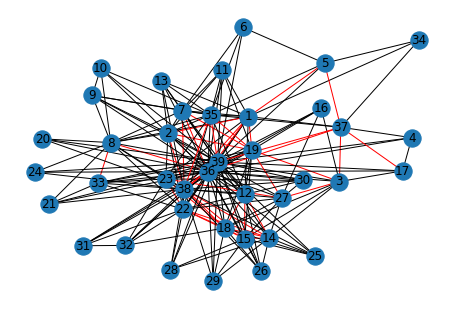

In [21]:
colors = ['r' if edge in added_edges else 'k' for edge in G.edges()] 
nx.draw(G, with_labels=True, edge_color=colors)

In [22]:
query_list = list()
i = 0
while i < 20:
    a = random.randint(1,len(G.nodes))
    b = random.randint(1,len(G.nodes))
    pair = sorted((a,b))
    if (a==b or (pair in query_list)):
        continue
    query_list.append(pair)
    i +=1


In [23]:
for i in range(20):
    See_full_route(G,query_list[i][0],query_list[i][1])

shortest distance:

3
route from target:

[34, 1]
route from source:

[19, 1]
entire route:

[19, 1, 34]
we have skipped 18 nodes from a graph with 39, 
    so we have skipped 46.15384615384615% of the nodes in our search space.
shortest distance:

2
route from target:

[19, 36]
route from source:

[17, 36]
entire route:

[17, 36, 19]
we have skipped 21 nodes from a graph with 39, 
    so we have skipped 53.84615384615385% of the nodes in our search space.
shortest distance:

2
route from target:

[21, 36]
route from source:

[13, 36]
entire route:

[13, 36, 21]
we have skipped 24 nodes from a graph with 39, 
    so we have skipped 61.53846153846154% of the nodes in our search space.
shortest distance:

1
route from target:

[35]
route from source:

[6, 35]
entire route:

[6, 35]
we have skipped 27 nodes from a graph with 39, 
    so we have skipped 69.23076923076923% of the nodes in our search space.
shortest distance:

3
route from target:

[34, 1]
route from source:

[33, 23, 1]
ent

In [24]:
G_original = nx.Graph()
graph = open("road-chesapeake.txt","r")
Connect(G_original,graph)

39
170


In [25]:
def See_full_route_constract(G, s, t):
    minimum, merge_node, SP_s, SP_t, parent_s, parent_t = GetDistance(G, s, t)
    # print("shortest distance between source node %d to target node %d:"%(s,t))
    if minimum == math.inf:
        print("no path between source node %d to target node %d"%(s,t))
        return
    # has_path_list.append([s,t])
    # print(minimum)
    route_from_source = Route_dijkstra(parent_s, merge_node)
    # show route
    # print("route from source node %d:"%s)
    # print(route_from_source)
    route_from_target = Route_dijkstra(parent_t, merge_node)
    # show route
    # print("route from target node %d:"%t)
    # print(route_from_target)
    route = route_from_source + route_from_target[::-1][1:]
    # show route
    # print("entire route:")
    # print(route)
    # unvisited = 0
    # for s_node, s_dist in SP_s.items():
    #     for t_node, t_dist in SP_t.items():
    #         if s_node == t_node and s_dist == t_dist == math.inf:
    #             unvisited += 1
    # print(f"""we have skipped {unvisited} nodes from a graph with {len(G)}, 
    # so we have skipped {unvisited/len(G)*100}% of the nodes in our search space.""")
    # print("\n\n")
    # print([minimum, route])

In [26]:
def dijkstra_with_contraction(G, source, destination, contracted = None):
    nx.set_node_attributes(G, {contracted: True}, 'contracted')
    
        
    shortest_path = dict()
    heap = list()
    
    for i in G.nodes():
        if not nx.get_node_attributes(G, 'contracted')[i]:
            shortest_path[i] = math.inf
            heap.append(i)
    shortest_path[source] = 0
    
    while len(heap)>0:
        q = min(heap, key= lambda node : shortest_path[node])
        if q == destination:
            nx.set_node_attributes(G, {contracted: False}, 'contracted')
            return shortest_path[q]
        heap.remove(q)
        # G[q] are incident edges of q
        for v in G[q]:
            # if the node is contracted, skip it
            if not nx.get_node_attributes(G, 'contracted')[v]:
                distance = shortest_path[q] + G[q][v]['weight']
                if distance < shortest_path[v]:
                    shortest_path[v] = distance
    nx.set_node_attributes(G, {contracted: False}, 'contracted')
    
    # can not reach the destination
    return math.inf

In [43]:
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra
sd_a = datetime.now()
for i in range(len(query_list)):
    distance = dijkstra_with_contraction(G_original, query_list[i][0], query_list[i][1])
sd_b = datetime.now()
((sd_b - sd_a).total_seconds())/len(query_list)

0.0054453

In [44]:
ch_a = datetime.now()
for i in range(len(query_list)):
    See_full_route_constract(G, query_list[i][0], query_list[i][1])
ch_b = datetime.now()
((ch_b - ch_a).total_seconds())/len(query_list)

0.0012467000000000001